In [1]:
import numpy as np
import seaborn as sns
import scipy.io as spoi
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

def Construct_G_big(G, S_e, M, mar_model): # a function by magnitude bias correction after iSDR
    # G: gain matrix x mutivariate autoregressive model
    # S_e: estimated brain activity from iSDR
    # M: EEG/MEG measurements
    # mar_model: order of the mutivariate autoregressive model
    # vec(M) = G x vec(S_e)
    n_c, n_t2 = np.shape(M)      
    n_s, n_t = np.shape(S_e)
    x,y = np.shape(G)
    n_shift = mar_model
    X = []
    Y = []
    data = []
    for i in range(n_t2):
        for k in range(n_c):
            for j in range(n_shift*n_s):
                X.append(j+n_s*i)
                Y.append(k+n_c*i)
        Z = G.reshape(-1)
        data.extend(Z)
    A= sp.sparse.csc_matrix((np.array(data), (np.array(Y),np.array(X))), shape = (n_c*n_t2, n_s*n_t))
    return A # build A such that   vec(M) = A x vec(S_e) , where M:measurements, S_e: estimated brain activity

%matplotlib inline
axisfsize = 17
fsize = 17
rc={'axes.labelsize': axisfsize, 'font.size': axisfsize, 'legend.fontsize': axisfsize, 'axes.titlesize': axisfsize,
    'xtick.labelsize' : axisfsize, 'ytick.labelsize' : axisfsize, 'axes.labelweight': 'bold', "lines.linewidth": 2.5}
sns.set(rc=rc)

# A brief description of the data
This data is taken from the dataset described in more details in [1]. The MEG measurement was aquired during a face recognition task. The cortical surface is divided into 562 regions using the mutual nearest neighbor parcellation algorithm [2]. The diffusion MR data is used to estimate the structural connectivity between these cortical regions.

[1] D. G. Wakeman et al., "A multi-subject, multi-model human neuroimaging dataset," Scientific Data, 2015.

[2] B. Belaoucha et al., "Cortical Surface Parcellation via dMRI Using Mutual Nearest Neighbor Condition," IEEE 13th International Symposium on Biomedical Imaging (ISBI), pp. 903-906, 2016.


# run in the terminal 
iSDR_p S1_data_p3.mat 10 7 1e-7 results_p3_3.mat 1 1

this results to the following:

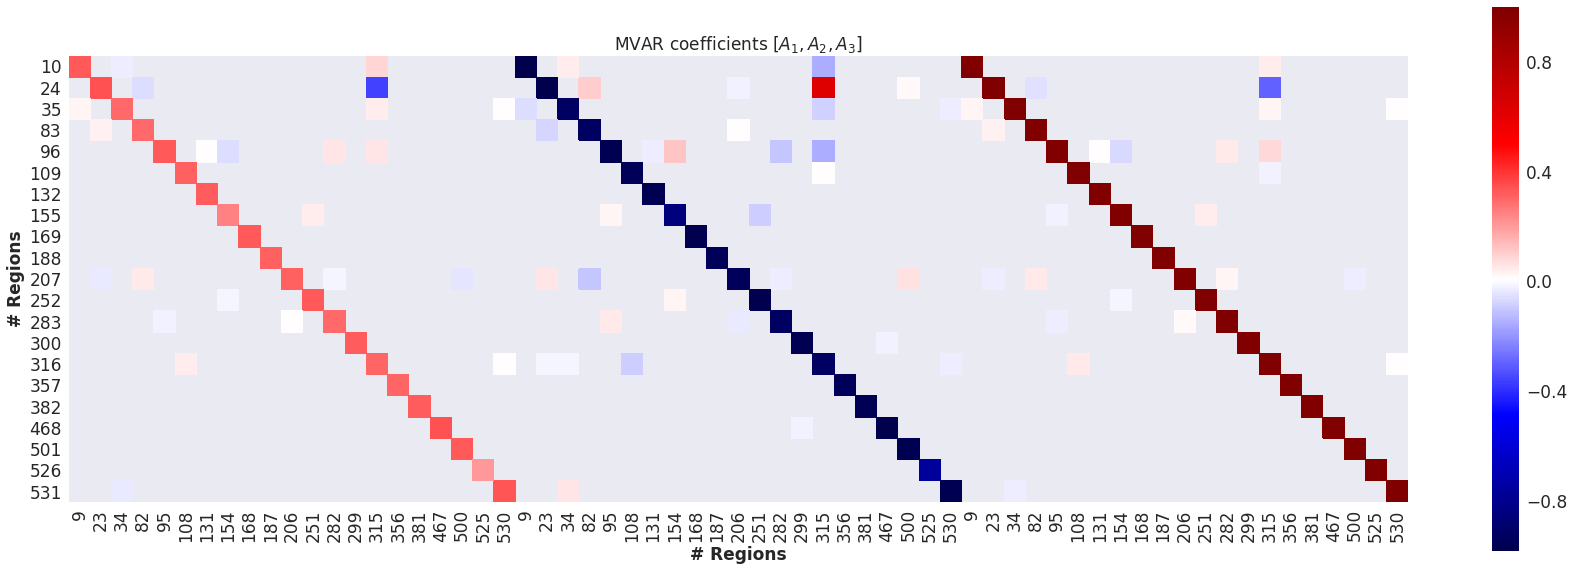

In [2]:
# after 4 iteration, we end up with 16 active regions (exe time few sec)
path = "results_p3_3.mat"
Result=spoi.loadmat(path)
S = Result['S estimate']
n_t_s, n_s = np.shape(S)
p=3
Sx = S.T.copy()
n_sources=[]
label = (Result['Active set']).astype(int)
p = 3
for i in range(3):
    n_sources.extend(label)
n_s = len(label)
MVAR = Result['MVAR']
df = pd.DataFrame(MVAR, index = label+1, columns = n_sources)
m = np.where(np.absolute(MVAR)>1e-2*np.max(np.absolute(MVAR)))
mask = np.ones(np.shape(MVAR))
mask[m[0], m[1]] = 0

plt.figure(figsize=(30,10))
sns.heatmap(df, square=True, cmap= "seismic", mask = mask)
plt.xlabel("# Regions")
plt.ylabel("# Regions")
plt.title(r"MVAR coefficients $[A_1, A_2, A_3]$")
plt.show()
path = "S1_data_p3.mat"
data=spoi.loadmat(path)
M = data['M']
G = data['G']
G_ac = G[:, label]
Me = np.dot(G_ac, S.T)
samples = np.array(data['time'][0])

# Brain network for the three time lags (black, blue, green)

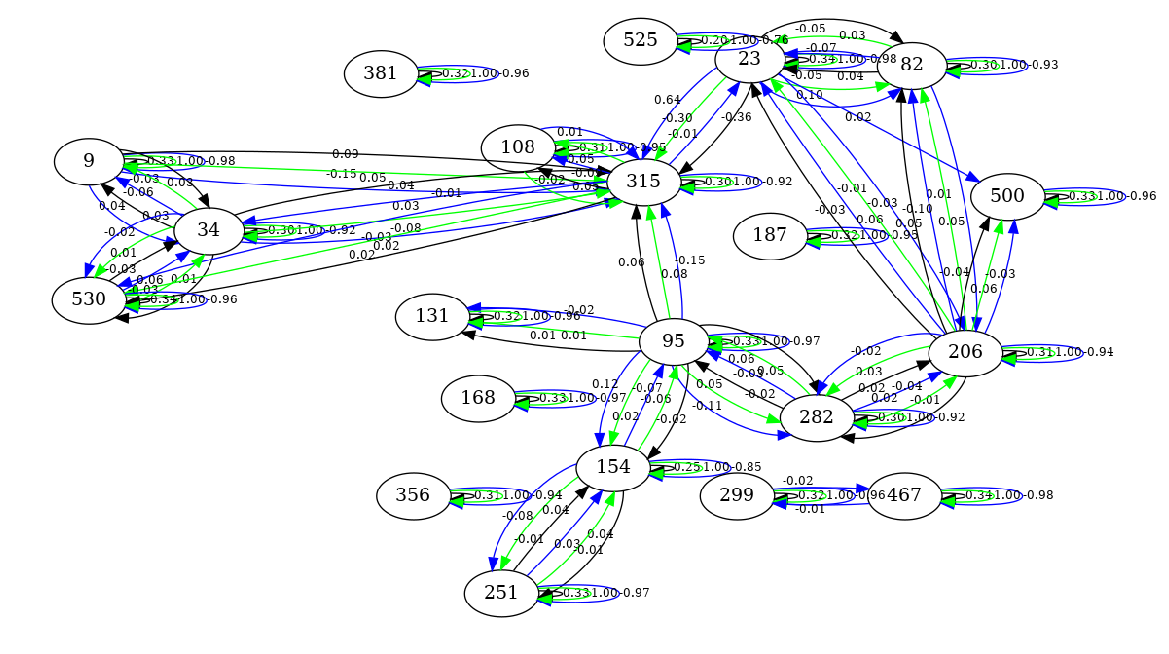

In [3]:
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
img=mpimg.imread("Brain_network.gv.png")
plt.imshow(img)
plt.axis('off')
plt.show()

# Normalized active brain regions (after Bias correction)
<img src="BrainActiveReg_abc.png">

# Magnitude bias correction using least square 

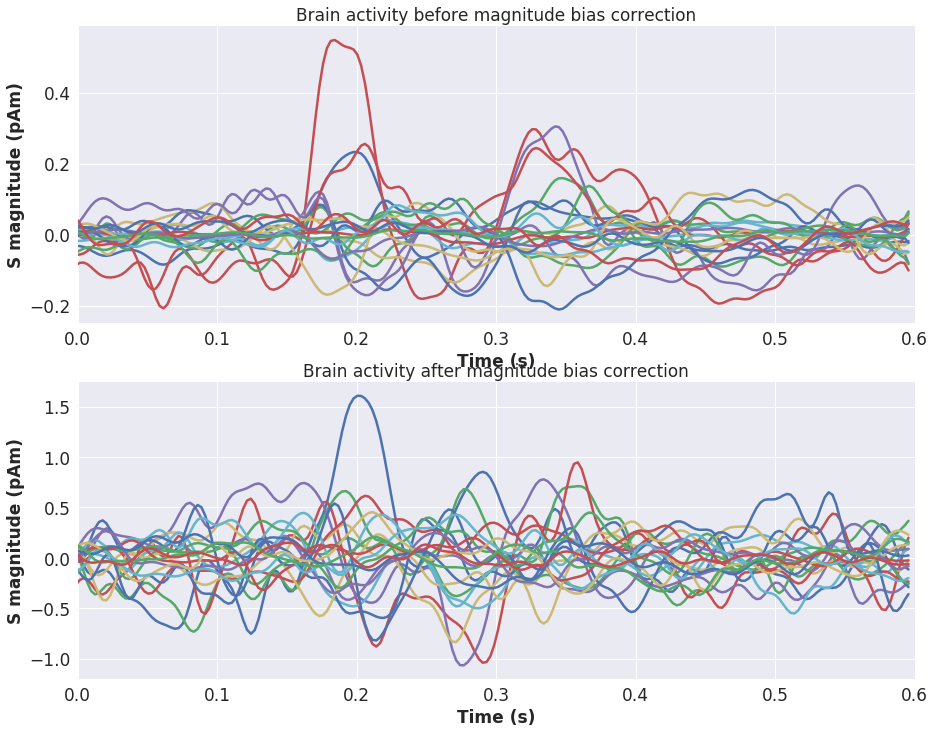

In [4]:
X = np.dot(G_ac, MVAR)
G_d = Construct_G_big(X, Sx, M[:, :], p)
Wx = (M.T).reshape(-1)
S_es = sp.sparse.linalg.lsmr(G_d, Wx, atol=1e-25, btol=1e-25)
S_es = S_es[0]
S_es = np.reshape(S_es, np.shape(Sx), order = 'F')


plt.figure(figsize=(15,12))
plt.subplot(211)
plt.plot(samples[:-1], S[p:, :]*1e12)
plt.xlim([0, 0.6])
plt.ylabel("S magnitude (pAm)")
plt.xlabel("Time (s)")
plt.title("Brain activity before magnitude bias correction")
plt.subplot(212)
plt.plot(samples[:-1], S_es[:, p:].T*1e12)
plt.xlim([0, 0.6])
plt.ylabel("S magnitude (pAm)")
plt.xlabel("Time (s)")
plt.title("Brain activity after magnitude bias correction")
plt.show()

# Right fusiform area activation (increase of activation after ~= 170ms)

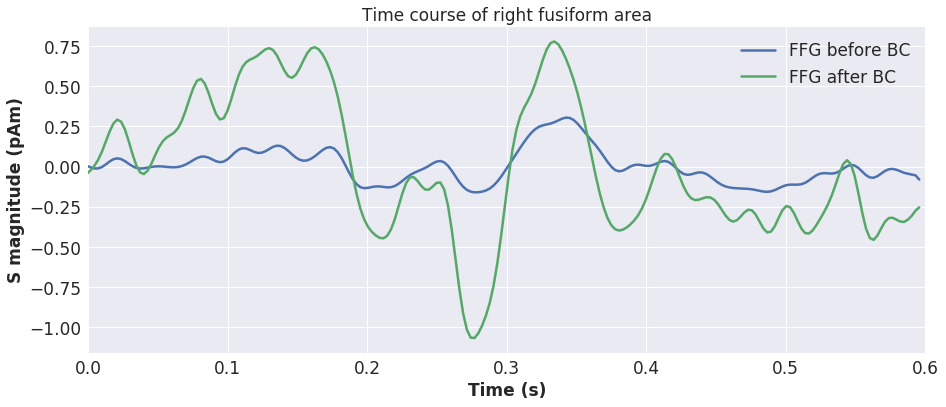

In [5]:
rffg = 82
ffg = np.where(label == rffg)[0][0]
plt.figure(figsize=(15,6))
plt.plot(samples[:-1], 1e12*Sx[ffg, p:], label="FFG before BC")
plt.plot(samples[:-1], 1e12*S_es[ffg, p:], label="FFG after BC")
plt.xlim([0, 0.6])
plt.ylabel("S magnitude (pAm)")
plt.xlabel("Time (s)")
plt.title("Time course of right fusiform area")
plt.legend()
plt.show()